In [48]:
import os, pydicom, argparse
import nibabel as nib
import numpy as np
import ipywidgets as ipw


In [116]:
os.uname()[1]

'img1'

In [97]:
#input variables
input_nifti='/data/TMORPH/I3CR/MW101_MR_tx1_GK/test/out1_Tum1_LFront.nii'
input_dcm='/data/TMORPH/I3CR/MW101_MR_tx1_GK/test/study2'
output_dcm='/data/TMORPH/I3CR/MW101_MR_tx1_GK/test/out1_Tum1_LFront_on_study2_flipx'

try:
    os.mkdir(output_dcm)
except OSError as error:
    print(error)      

newSeriesInstanceUID='auto'
newSeriesDescription='series generated by nifti2dcm'
newSeriesNumber='2001'

isSC=False #not supported
flipX,flipY,flipZ=True,False,False


[Errno 17] File exists: '/data/TMORPH/I3CR/MW101_MR_tx1_GK/test/out1_Tum1_LFront_on_study2_flipx'


In [98]:
def sort_dcms_by_slice_pos(input_dicom_path,dcm_files,stop_before_pixels=True):
    '''
    Sort DICOMs from an input directory (assumed to contain a single study) according to slice position
    Output: a sorted list of DICOM datasets
    '''
    dcmss=[]
    for idx,dcm in enumerate(dcm_files):
        ds = pydicom.dcmread(os.path.join(input_dicom_path,dcm), stop_before_pixels)
        if idx==0:           
            if 'ImagePositionPatient' in ds: sortTag='ImagePositionPatient'
            elif 'SliceLocation' in ds: sortTag='SliceLocation'
            else: return None
        if not sortTag in ds: return None
        if sortTag=='ImagePositionPatient': z=ds.ImagePositionPatient[2]
        else: z=ds.SliceLocation
        dcmss+=[dict(file=dcm,dataset=ds,z=z)]
    return sorted(dcmss, key=lambda dcms: dcms['z'])

def voxel_array_from_sorted_dicoms(dicomsSorted):
    '''
    extract the 3D voxel array from a list of sorted DICOM objects.
    '''
    ind=0
    
    if len(dicomsSorted) < 1: return None
    ds0=dicomsSorted[0]['dataset']
    
    imwidth,imheight,imdepth=ds0.Rows,ds0.Columns,len(dicomsSorted)
    pixeldata_type=ds0.pixel_array.dtype
    voxels=np.zeros([imwidth,imheight,imdepth],dtype=pixeldata_type)
    
    for i in range(len(dicomsSorted)):
        voxels[:,:,i]=np.transpose(dicomsSorted[i]['dataset'].pixel_array)
        
    return voxels


In [99]:
#load NIFTI image
nii=nib.load(input_nifti)
dcm_in_files=next(os.walk(input_dcm))[2]
numberOfDicomImages = len(dcm_in_files)
dcm_in_sorted=sort_dcms_by_slice_pos(input_dcm,dcm_in_files,stop_before_pixels=False)

ds0=dcm_in_sorted[0]['dataset']
dcm_pixeldata_type=ds0.pixel_array.dtype

dcm_in_voxels=voxel_array_from_sorted_dicoms(dcm_in_sorted)
nii_in_voxels=nii.get_fdata().astype(ds0.pixel_array.dtype)

if dcm_in_voxels.shape != nii_in_voxels.shape:
    print ('NIFTI and DICOM image shapes don\'t match!')
   

In [100]:
if flipX: nii_in_voxels=np.flip(nii_in_voxels,0)
if flipY: nii_in_voxels=np.flip(nii_in_voxels,1)
if flipZ: nii_in_voxels=np.flip(nii_in_voxels,2)

siUID=pydicom.uid.generate_uid() if newSeriesInstanceUID == 'auto' else newSeriesInstanceUID
sDescr=ds.SeriesDescription if newSeriesDescription is None else newSeriesDescription
sNumber=ds.SeriesNumber if newSeriesNumber is None else newSeriesNumber

#cycle through input DICOM datasets and replace voxels.
for i in range(len(dcm_in_sorted)):
    ds=dcm_in_sorted[i]['dataset']
    ds.PixelData=np.transpose(nii_in_voxels[:,:,i]).tobytes()
    ds[0x0020, 0x000e].value=siUID
    ds[0x0008,0x103e].value=sDescr
    ds[0x0020, 0x0011].value=sNumber    
    ds.save_as(output_dcm+'/'+str(i)+'.dcm')
    

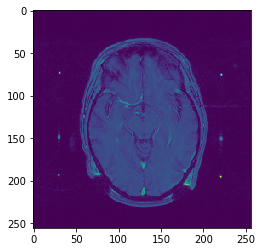

In [78]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(ds.pixel_array, interpolation='nearest')
